In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
from deepregression import Sddr_Single, Sddr
from dataset import MyDataset

# todo

sddr single:
input to NN cannot be dicts


SDDR: may be we make our own get_parameters?

In [4]:
def train():
    
    cur_distribution = "poisson"
    family = {'normal':{'loc': 'whateva', 'scale': 'whateva2'}, 'poisson': {'rate': 'whateva'}, 'binomial':{'n': 'whateva', 'p': 'whateva'}}
    
    regularization_params = dict()
    regularization_params["rate"] = 1.   # already mutiplied in full_P
        
    x_path = r'./example_data/simple_gam/X.csv'
    y_path = r'./example_data/simple_gam/Y.csv'
    
    formulas = dict()
    formulas['rate'] = '~1++spline(x2, bs="bs",df=9)+spline(x1, bs="bs",df=9)+d1(x1)+d2(x2)'
    
    deep_models_dict = dict()
    deep_models_dict['rate'] = dict()
    deep_models_dict['rate']['d1'] = nn.Sequential(nn.Linear(1,15))
    deep_models_dict['rate']['d2'] = nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8))
    
    deep_shapes = dict()
    deep_shapes['rate'] = {"d1" : 15, "d2" : 8}
    
    
    dataset = MyDataset(x_path, y_path,family, formulas,cur_distribution, deep_models_dict,deep_shapes)
    loader = DataLoader(
        dataset,
        batch_size=1000,
    )
    parsed_formula_contents = dataset.get_parsed_formula_content()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bignet = Sddr(cur_distribution, regularization_params, parsed_formula_contents)
    bignet = bignet.to(device)
    optimizer = optim.RMSprop(bignet.parameters())

    bignet.train()
    print('Begin training ...')
    for epoch in range(1, 2500): 

        for batch in loader:
            target = batch['target'].to(device)
            meta_datadict = batch['meta_datadict']          # .to(device) should be improved 
            meta_datadict['rate']['structured'] = meta_datadict['rate']['structured'].to(device)
            meta_datadict['rate']['d1'] = meta_datadict['rate']['d1'].to(device)
           
            optimizer.zero_grad()
            output = bignet(meta_datadict)
            loss = torch.mean(bignet.get_loss(target))
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch,loss.item()))
    for param in bignet.parameters():
        print(param.size())
    return list(bignet.parameters())[-2].detach().numpy(), meta_datadict

In [5]:
param, meta_datadict = train()    # using adam optimizer can have smooth decreasing loss, using rmsprop the losses converge to a high value?

results from split formula
1++spline(x2,bs="bs",df=9)+spline(x1,bs="bs",df=9)
['d1(x1)', 'd2(x2)']
Begin training ...
Train Epoch: 100 	 Loss: 20.284775
Train Epoch: 200 	 Loss: 11.308476
Train Epoch: 300 	 Loss: 10.752113
Train Epoch: 400 	 Loss: 10.636162
Train Epoch: 500 	 Loss: 10.621563
Train Epoch: 600 	 Loss: 10.605463
Train Epoch: 700 	 Loss: 10.623966
Train Epoch: 800 	 Loss: 10.618565
Train Epoch: 900 	 Loss: 10.608707
Train Epoch: 1000 	 Loss: 10.609525
Train Epoch: 1100 	 Loss: 10.611541
Train Epoch: 1200 	 Loss: 10.609047
Train Epoch: 1300 	 Loss: 10.606302
Train Epoch: 1400 	 Loss: 10.604847
Train Epoch: 1500 	 Loss: 10.603293
Train Epoch: 1600 	 Loss: 10.601628
Train Epoch: 1700 	 Loss: 10.598497
Train Epoch: 1800 	 Loss: 10.596050
Train Epoch: 1900 	 Loss: 10.594291
Train Epoch: 2000 	 Loss: 10.591511
Train Epoch: 2100 	 Loss: 10.588743
Train Epoch: 2200 	 Loss: 10.586768
Train Epoch: 2300 	 Loss: 10.583268
Train Epoch: 2400 	 Loss: 10.578945
torch.Size([15, 1])
torch.S

In [6]:
b_aut = meta_datadict['rate']['structured'].detach().numpy()
b_aut.shape

(1000, 19)

In [7]:
param

array([[ 1.8078665 ,  2.4876795 ,  2.2615604 ,  1.8636874 ,  1.2194953 ,
         0.57308656, -0.07331183, -0.75366086, -1.2318724 , -1.4570577 ,
         2.1323247 ,  1.654576  ,  0.69045466, -0.34657905, -0.6756961 ,
        -0.32131043,  0.6148967 ,  1.5213356 ,  2.0332365 ]],
      dtype=float32)

## evaluation

In [8]:
true_coeff = pd.read_csv (r'example_data/simple_gam/true_coefficients.csv',sep=';',header=None).values
B = pd.read_csv (r'example_data/simple_gam/B.csv',sep=';',header=None).values
#B = pd.read_csv (r'B_gen.csv',sep=';',header=None).values
#B=B[:,1:]
X = pd.read_csv (r'../example_data/simple_gam/X.csv',sep=';',header=None).values
print(true_coeff.shape)

(19, 1)


In [9]:
print(meta_datadict['rate']['structured'].size() == B.shape)


True


In [10]:
hatY = np.matmul(B[:,1:10],true_coeff[1:10])
print(hatY.shape)

(1000, 1)


In [11]:
pred_coeff = param
pred_coeff = np.transpose(pred_coeff)
print(pred_coeff.shape)
hatY_pred = np.matmul(b_aut[:,1:10],pred_coeff[1:10])

(19, 1)


In [12]:
firstCov = X[:,0] 
sortedHatY = [x for _,x in sorted(zip(firstCov,hatY))]
sortedHatY_pred = [x for _,x in sorted(zip(firstCov,hatY_pred))]

Text(0.5, 1.0, 'PySDDR_coefficient')

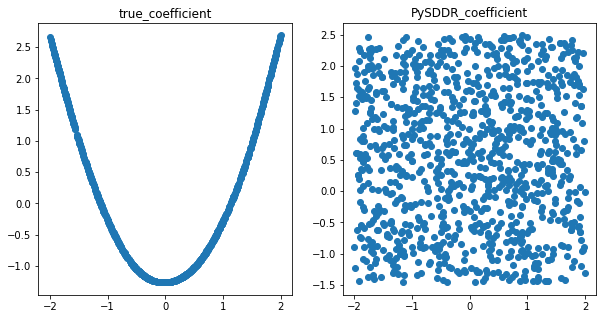

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(np.sort(firstCov), sortedHatY)
plt.title('true_coefficient')
plt.subplot(1,2,2)
plt.scatter(np.sort(firstCov), sortedHatY_pred)
plt.title('PySDDR_coefficient')

# test Sddr_Single

In [15]:
deep_shapes = {"dm1" : 5, "dm2" : 8}

net2= nn.Sequential(nn.Linear(10,3),nn.ReLU(), nn.Linear(3,8))

In [16]:
deep_models_dict = {"dm1" : nn.Linear(10,5, bias = False), "dm2" : net2}

In [17]:
struct_shapes = 10

In [18]:
P = np.eye(10)

In [19]:
data = torch.ones(20,10)
datadict = {"structured": data, "dm1": data, "dm2": data}

In [20]:
net = deepregression.Sddr_Single(deep_models_dict, deep_shapes, struct_shapes, P)

In [21]:
net(datadict)

tensor([[-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226],
        [-0.0226]], grad_fn=<AddBackward0>)

In [22]:
net.get_regularization()

tensor([[0.3598]], grad_fn=<MmBackward>)

In [23]:
for i in net.parameters():
    print(i)

Parameter containing:
tensor([[-0.1935,  0.0301, -0.0123,  0.0357, -0.2134, -0.0730, -0.0048, -0.2697,
          0.0231, -0.2892],
        [-0.3097, -0.1286,  0.0496, -0.0402,  0.1834,  0.2827,  0.1901, -0.0984,
         -0.1785, -0.1594],
        [ 0.2092, -0.2141,  0.1104, -0.1351,  0.1407, -0.0386, -0.2448, -0.3022,
          0.1182,  0.1253],
        [ 0.0958,  0.1131, -0.0343, -0.1154,  0.0705, -0.1790,  0.1225, -0.0100,
          0.0172,  0.1540],
        [-0.0907, -0.0408, -0.2554,  0.1053,  0.2946,  0.1850, -0.2062, -0.1011,
         -0.2434, -0.2904]], requires_grad=True)
Parameter containing:
tensor([[ 0.0723, -0.3095,  0.2522, -0.2184, -0.3135,  0.1931,  0.0806,  0.1451,
         -0.1344, -0.0403],
        [ 0.0625, -0.2454,  0.2284,  0.1962,  0.1202, -0.1369, -0.0387, -0.1889,
         -0.3157,  0.2815],
        [-0.2833,  0.1714, -0.1251, -0.1508,  0.1746,  0.1788,  0.2207,  0.1514,
          0.1758, -0.2217]], requires_grad=True)
Parameter containing:
tensor([-0.1996,  0.

In [53]:
for i in bignet.parameters():
    print(i)

Parameter containing:
tensor([[-0.6698, -0.1423],
        [ 0.5038,  0.0981],
        [-0.1744, -0.1339],
        [-0.4113,  0.3310],
        [-0.4738, -0.2220]], requires_grad=True)
Parameter containing:
tensor([[ 0.1450,  0.1367,  0.1768,  0.1635, -0.0770,  0.1613, -0.0192,  0.0786,
         -0.2005, -0.2166, -0.2112,  0.0377,  0.0462,  0.1035,  0.1268, -0.0238,
          0.0126, -0.0916,  0.1823]], requires_grad=True)
Parameter containing:
tensor([[-0.1046,  0.2764, -0.3203, -0.0709,  0.2124]], requires_grad=True)


# Test Sddr

In [838]:
family= "normal"


In [839]:

parsed_formula_contents = dict()
parsed_formula_contents["loc"] = {"deep_models_dict": deep_models_dict, "deep_shapes": deep_shapes, "struct_shapes": struct_shapes, "P": P}
parsed_formula_contents["scale"] = {"deep_models_dict": dict(), "deep_shapes": dict(), "struct_shapes": struct_shapes, "P": P}



In [840]:
regularization_params = dict()

regularization_params["loc"] = 1.
regularization_params["scale"] = 1.


In [841]:
meta_datadict = dict()

'''
formulas = dict()

formulas['loc'] = '1 + s(x1) + s(x2) + d(x1) + d(x2)'
'
formulas['scale'] = '1 + s(x)' 

meta_datadict = parse_formulas(formulas, data)
        
'''

meta_datadict["loc"] = datadict # datadict = {"structured": data, "dm1": data, "dm2": data}
meta_datadict["scale"] = {"structured": data}




In [842]:
bignet = deepregression.Sddr(family, regularization_params, parsed_formula_contents)

In [843]:
bignet(meta_datadict)

loc
scale


Normal(loc: torch.Size([20, 1]), scale: torch.Size([20, 1]))

In [844]:
for i in bignet.children():
    print(i)

Sddr_Single(
  (dm1): Linear(in_features=10, out_features=5, bias=False)
  (dm2): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=8, bias=True)
  )
  (structured_head): Linear(in_features=10, out_features=1, bias=False)
  (deep_head): Linear(in_features=13, out_features=1, bias=False)
)
Sddr_Single(
  (structured_head): Linear(in_features=10, out_features=1, bias=False)
)


In [845]:
for i in bignet.parameters():
    print(i)

Parameter containing:
tensor([[-0.0450,  0.3132, -0.2533, -0.0663,  0.1513,  0.1618, -0.1711,  0.1751,
          0.2034, -0.1013],
        [ 0.1457, -0.1887,  0.1578, -0.0177, -0.0884, -0.2482,  0.1933,  0.1885,
          0.1223,  0.1456],
        [-0.2872,  0.2873,  0.0221,  0.1267, -0.1926, -0.1228, -0.1013, -0.3115,
         -0.1070,  0.3092],
        [ 0.2323, -0.0799,  0.2225,  0.0531,  0.0059,  0.1509, -0.1401,  0.2687,
          0.1905, -0.2308],
        [-0.0035, -0.1833, -0.1211, -0.0225, -0.2246,  0.0049, -0.0644, -0.2636,
         -0.1963, -0.2150]], requires_grad=True)
Parameter containing:
tensor([[ 0.1504,  0.0733, -0.0326,  0.1949, -0.0519, -0.0607, -0.0694,  0.0783,
         -0.2417, -0.0261],
        [-0.2603, -0.0073,  0.2344, -0.2413, -0.1986, -0.1428, -0.2594,  0.0118,
         -0.1722,  0.1692],
        [ 0.0141, -0.2903,  0.2476, -0.2810, -0.0929, -0.2952,  0.1316, -0.0939,
          0.1434, -0.0977]], requires_grad=True)
Parameter containing:
tensor([0.2397, 0.13

In [846]:
Y = torch.ones([20,1])

In [847]:
Y.size()

torch.Size([20, 1])

In [848]:
loss = bignet.get_loss(Y)

In [850]:
loss.mean().backward()

# testing for dictionary as input to neural network module

In [9]:
import torch

In [171]:
class testnn(nn.Module):
    
    def __init__(self):
        super(testnn, self).__init__()
        
        
        self.weights = nn.Parameter(torch.ones(784, 10) )
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xa):
        #xa = datadict["a"]
        #xb = datadict["b"]
        out = xa @ self.weights + xa @ self.weights + self.bias
        return out
  

In [172]:
testnn_obj = testnn()

In [173]:
data = torch.ones([784,10]).T

In [174]:
out = testnn_obj(data)

In [175]:
param_list = []
for i in testnn_obj.parameters():
    param_list.append(i)

In [176]:
loss  = (out-100)**2

loss.mean().backward()

In [177]:
param_list[0].grad


tensor([[587.2000, 587.2000, 587.2000,  ..., 587.2000, 587.2000, 587.2000],
        [587.2000, 587.2000, 587.2000,  ..., 587.2000, 587.2000, 587.2000],
        [587.2000, 587.2000, 587.2000,  ..., 587.2000, 587.2000, 587.2000],
        ...,
        [587.2000, 587.2000, 587.2000,  ..., 587.2000, 587.2000, 587.2000],
        [587.2000, 587.2000, 587.2000,  ..., 587.2000, 587.2000, 587.2000],
        [587.2000, 587.2000, 587.2000,  ..., 587.2000, 587.2000, 587.2000]])

In [170]:
testnn_obj.zero_grad()

### This code can be found in deepregression.py and dataset.py so should not be used here so we only make changes to one code and don't get confused. Remove after checking with others that it is exact duplicate ###

In [24]:

class Sddr_Single(nn.Module):
    
    def __init__(self, deep_models_dict, deep_shapes, struct_shapes, P):
        """
        deep_models_dict: dictionary where key are names of deep models and values are objects that define the deep models
        struct_shapes: number of structural features
        P: numpy matrix for the smoothing regularization (with added zero matrix in the beginning for the linear part)
        
        """
        super(Sddr_Single, self).__init__()
        self.P = P
        self.deep_models_dict = deep_models_dict
        
        #register external neural networks
        for key, value in deep_models_dict.items():
            self.add_module(key,value)
        
        
        self.structured_head = nn.Linear(struct_shapes,1, bias = False)
        
        if len(deep_models_dict) != 0:
            output_size_of_deep_models  = sum([deep_shapes[key] for key in deep_shapes.keys()])
            self.deep_head = nn.Linear(output_size_of_deep_models,1, bias = False)
            self._deep_models_exist = True
        else:
            self._deep_models_exist = False
        
              
        
    def _orthog_layer(self, Q, Uhat):
        """
        Utilde = Uhat - QQTUhat
        """
        print(Q)
        print(Q.T)
        Projection_Matrix = Q @ Q.T
        print(Projection_Matrix)
        Utilde = Uhat - Projection_Matrix @ Uhat
        
        return Utilde
    
    
    def forward(self, datadict):
        """Comment 6.8.2020 We checked that we can actually have a dictionary as an input here. that should work fine"""
        
        X = datadict["structured"]
        
        if self._deep_models_exist:
            Q, R = torch.qr(X)

            Uhat_list = []
            for key in self.deep_models_dict.keys(): #assume that the input for the NN has the name of the NN as key
                net = self.deep_models_dict[key]
                Uhat_list.append(net(datadict[key]))
            
            Uhat = torch.cat(Uhat_list, dim = 1) #concatenate the outputs of the deep NNs

            Utilde = self._orthog_layer(Q, Uhat)
            
            deep_pred = self.deep_head(Utilde)
        else:
            deep_pred = 0
        
        structured_pred = self.structured_head(X)
        
        pred = structured_pred + deep_pred
        
        return pred
    
    def get_regularization(self):
        P = torch.from_numpy(self.P).float() # should have shape struct_shapes x struct_shapes, numpy array
        weights = self.structured_head.weight #should have shape 1 x struct_shapes
        
        
        regularization = weights @ P @ weights.T
        
        return regularization
        
        
        
class Sddr(nn.Module):
    
    def __init__(self, family, regularization_params, parsed_formula_contents):
        """
        family: string e.g. "gaussian", "binomial"...
        regularization_params: smoothing parameters
        parsed_formula_contents: dictionary with keys being parameters of the distribution, e.g. "eta" and "scale"
        and values being dicts with keys deep_models_dict, struct_shapes and P (as used in Sddr_Single)
        """
        super(Sddr, self).__init__()
        self.family = family
        self.regularization_params = regularization_params
        self.parameter_names = parsed_formula_contents.keys
        self.single_parameter_sddr_list = dict()
        for key, value in parsed_formula_contents.items():
            deep_models_dict = value["deep_models_dict"]
            deep_shapes = value["deep_shapes"]
            struct_shapes = value["struct_shapes"]
            P = value["P"]
            self.single_parameter_sddr_list[key] = Sddr_Single(deep_models_dict, deep_shapes, struct_shapes, P)
            
            #register the Sddr_Single network
            self.add_module(key,self.single_parameter_sddr_list[key])
                

        #define distributional layer
        if family == "normal":
            self.distribution_layer_type = torch.distributions.normal.Normal
        elif family == "poisson":
            self.distribution_layer_type = torch.distributions.poisson.Poisson
    
    def _distribution_trafos(self,pred):
        #applies the specific transformations to the prediction so they they correspond to the restrictions
        #of the parameters
        #this is family specific
        pred_trafo = dict()
        add_const = 1e-8
        
        family = self.family
        if family == "normal":
            pred_trafo["loc"] = pred["loc"]
            pred_trafo["scale"] = add_const + pred["scale"].exp()
        elif family == "poisson":
            pred_trafo["rate"] = add_const + pred["rate"].exp()
        
        return pred_trafo
    
    def forward(self,meta_datadict):
        
        self.regul = 0
        pred = dict()
        for parameter_name, data_dict  in meta_datadict.items():
            sddr_net = self.single_parameter_sddr_list[parameter_name]
            pred[parameter_name] = sddr_net(data_dict)
            self.regul += sddr_net.get_regularization()*self.regularization_params[parameter_name]
            
        predicted_parameters = self._distribution_trafos(pred)
        
        #define distributional layer (takes eta and scale)
        self.distribution_layer = self.distribution_layer_type(**predicted_parameters)
        
        return self.distribution_layer
    
    def get_loss(self, Y):
    
#         regul = 0            # move to forward, or we need meta_datadict as input to get_loss
#         for parameter_name, data_dict  in meta_datadict.items():
#             sddr_net = self.single_parameter_sddr_list[parameter_name]
#             regul += sddr_net.get_regularization()*self.regularization_params[parameter_name]
        log_loss = -self.distribution_layer.log_prob(Y)
        loss = log_loss + self.regul
        
        return loss
        
        


In [2]:
class MyDataset(Dataset):
    def __init__(self):
        x_csv = pd.read_csv (r'./example_data/simple_gam/X.csv',sep=';',header=None)
        y_csv = pd.read_csv (r'./example_data/simple_gam/Y.csv',header=None)
        B_csv = pd.read_csv (r'./example_data/simple_gam/B.csv',sep=';',header=None)
        
        self.struct_data = torch.from_numpy(B_csv.values).float()
        self.deep_data = torch.from_numpy(x_csv.values).float()
        self.y = torch.from_numpy(y_csv.values).float()
        
    def __getitem__(self, index):
        struct = self.struct_data[index]
        deep = self.deep_data[index]
        gt = self.y[index]
        
        datadict = {"structured": struct, "dm1": deep}
        meta_datadict = dict()
        meta_datadict["rate"] = datadict
        
        return {'meta_datadict': meta_datadict, 'target': gt}        
    
    def __len__(self):
        return len(self.deep_data)

